### Shapes Dataset
We present the "shapes dataset" consisting of a training set of 60,000 examples, and a test set of 10,000 examples. Each example is a 784-dimensional vector, which when reformatted as an image has the appearance of one of 3 shapes - triangle, square or pizza.

Four flat binary data files are available on this site:

Shapes_1_1_Train_Features.dat: training set features (47040000 bytes) 
Shapes_1_1_Train_Labels.dat: training set labels (60000 bytes) 
Shapes_1_1_Test_Features.dat: training set features (7840000 bytes) 
Shapes_1_1_Test_Labels.dat: training set labels (10000 bytes)

Once you import a feature file by reading in all the bytes, you must partition the data into lists of 784 elements. Each of these lists can be viewed as an image of a handwritten digit by reformatting it as a 28x28 matrix.
Questions? Email: shashi@numericinsight.com
www.numericinsight.com

### Supervised learning model - Logistic Regression

In [61]:
import os, struct
import matplotlib as plt
from array import array as pyarray
import pandas as pd
from openpyxl import load_workbook
from pylab import *
from numpy import *
import numpy.linalg as LA

from sklearn import linear_model
from numpy.linalg import inv
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

### Load Training dataset

In [62]:
def load_NMNIST(dataset="training", digits=range(10), path=r'/Users/monikabansal/ucsc/MachineLearning/project/shapes_data'):
    
    if dataset == "training":
        fname_img = os.path.join(path, 'Shapes_1_1_Train_Features.dat')
        fname_lbl = os.path.join(path, 'Shapes_1_1_Train_Labels.dat')
    elif dataset == "testing":
        fname_img = os.path.join(path, 'Shapes_1_1_Test_Features.dat')
        fname_lbl = os.path.join(path, 'Shapes_1_1_Test_Labels.dat')
    else:
        raise ValueError("dataset must be 'testing' or 'training'")

    flbl = open(fname_lbl, 'rb')
    lbl = np.fromfile(flbl, dtype=np.uint8)
    flbl.close()

    fimg = open(fname_img, 'rb')
    img = np.fromfile(fimg, dtype=np.uint8)
    fimg.close()

    size=len(lbl)

    ind = [ k for k in range(size) if lbl[k] in digits ]
    N = len(ind)

    rows=28;cols=28;

    images = zeros((N, rows, cols), dtype=uint8)
    labels = zeros((N, 1), dtype=int8)
    for i in range(len(ind)):
        images[i] = array(img[ ind[i]*rows*cols : (ind[i]+1)*rows*cols ]).reshape((rows, cols))
        labels[i] = lbl[ind[i]]
    return images, labels

In [63]:
def vectortoimg(v,show=True):
    #vReshaped = v.reshape(28,28)
    plt.imshow(v.reshape(28, 28),interpolation='None', cmap='gray')
    plt.axis('off')
    if show:
        plt.show()

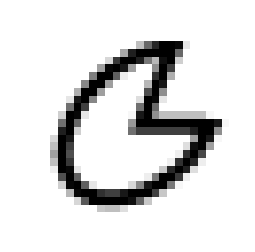

X: (60000, 784)
T: (60000, 1)


In [64]:
images, labels = load_NMNIST('training', digits=[0,1,2])

flatimages = list()
for i in images:
    flatimages.append(i.ravel())
X = asarray(flatimages) # X now contains 60000 feature vectors, each of dimension 784
T=labels # T contains class labels with 0->Triangle, 1->Square, 2->Pizza
vectortoimg(X[1])

print("X:" , X.shape)#, X[20:22,300:400])
print("T:" , T.shape)#, T)


Checking multiple training vectors by plotting images.
Be patient:


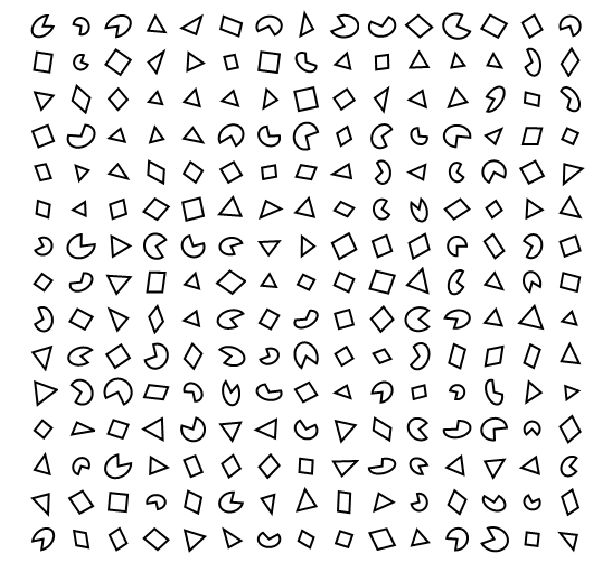

In [65]:
print("Checking multiple training vectors by plotting images.\nBe patient:")
plt.close('all')
fig = plt.figure(figsize=(10,10))
nrows=15
ncols=15
for row in range(nrows):
    for col in range(ncols):
        #print("row*ncols+col + 1", row*ncols+col + 1)
        plt.subplot(nrows, ncols, row*ncols+col + 1)
        vectortoimg(X[row*ncols+col + 1],show=False)
        #vectortoimg(X[np.random.randint(len(T))],show=False)
plt.show()

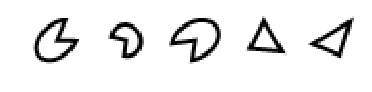

In [66]:
#Checking multiple training vectors by plotting images
def vectortoimgMlt(X,T,nrows,ncols):
    plt.close('all')
    fig = plt.figure()
    for row in range(nrows):
        for col in range(ncols):
            plt.subplot(nrows, ncols, row*ncols+col + 1)
            vectortoimg(X[row*ncols+col + 1],show=False)          
            #vectortoimg(X[np.random.randint(len(T))],show=False)
    plt.show()
    
vectortoimgMlt(X,T,1,5) # plot first 1 to 5

### Load Testing dataset

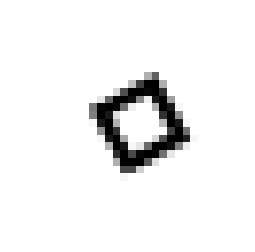

Xt: (10000, 784)
Tt: (10000, 1)


In [67]:
images, labels = load_NMNIST('testing', digits=[0,1,2])

flatimages = list()
for i in images:
    flatimages.append(i.ravel())
Xt = asarray(flatimages) # X now contains 60000 feature vectors, each of dimension 784
Tt = labels # T contains class labels with 0->Triangle, 1->Square, 2->Pizza
vectortoimg(Xt[8])

print("Xt:" , Xt.shape)#, X[20:22,300:400])
print("Tt:" , Tt.shape)#, T)

In [68]:
def vectortoimgRed(v,show=True):
    #vReshaped = v.reshape(14,14)
    #print("vReshaped", vReshaped.shape, vReshaped)
    plt.imshow(v.reshape(14, 14),interpolation='None', cmap='gray')
    plt.axis('off')
    if show:
        plt.show()

In [69]:
# Split result into classes - upto 5 classes

def splitDataIntoClasses(P,T):
    P1 = []
    P2 = []
    P3 = []       
    P4 = []
    P5 = []
    for i,j in enumerate(P):
        #print("i=",i , " j= ",j,"X[i]=", X[i])
        if(T[i] == 0) : 
            P1.append(j)
        elif(T[i] == 1) : 
            P2.append(j)
        elif(T[i] == 2) : 
            P3.append(j)
        elif(T[i] == 3) : 
            P4.append(j)
        else :
            P5.append(j)
    return(np.array(P1),np.array(P2),np.array(P3),np.array(P4),np.array(P5)) 

### Reduce from 784 dims to fewer Principal Component dims

In [70]:

scaler = StandardScaler()

# Fit on training set only
scaler.fit(X)

# Apply transform to both the training set and the test set
train_img = scaler.transform(X) # Training Image
test_img = scaler.transform(Xt) # Testing Image

# Make an instance of the Model
pca = PCA(.95)

# Fit PCA on Training set only
pca.fit(X)

print("Number of components choosen:" , pca.n_components_) #133
#print("Explained Variance:" , pca.explained_variance_)
print("Explained Variance Total:" , sum(pca.explained_variance_ratio_)) # 95%
#print("Explained Variance Ratio:" , pca.explained_variance_ratio_)

# 95% of the variance amounts to 133 principal components.

# Transform both Training and Test set
Xpca = pca.transform(X)
Xtpca = pca.transform(Xt)

print("Xpca:", Xpca.shape)
print("Xtpca:", Xtpca.shape)


/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Number of components choosen: 133
Explained Variance Total: 0.9500568078208754
Xpca: (60000, 133)
Xtpca: (10000, 133)


### Reduce to 2 PCA components

In [71]:
pca2 = PCA(n_components=2, svd_solver='full')

# Fit PCA on Training set only
pca2.fit(X)

print("Number of components choosen:" , pca2.n_components_) #133
print("Explained Variance Total:" , sum(pca2.explained_variance_ratio_)) # 95%
#print("Explained Variance Ratio:" , pca2.explained_variance_ratio_)

# 22% of the variance amounts to 2 principal components.

# Transform both Training and Test set
Xpca2 = pca2.transform(X)
Xtpca2 = pca2.transform(Xt)

print("Xpca2:", Xpca2.shape)
print("Xtpca2:", Xtpca2.shape)


Number of components choosen: 2
Explained Variance Total: 0.22164428463433766
Xpca2: (60000, 2)
Xtpca2: (10000, 2)


### Apply Logistic Regression to the Transformed PCA Components

In [72]:
# all parameters not specified, are set to their defaults
# default solver is incredibly slow which is why it was changed to 'lbfgs'
logisticRegr = LogisticRegression(solver = 'lbfgs',max_iter=1000,n_jobs=10,tol=0.0001,verbose=0, 
                                  warm_start=True)


In [73]:
#Training the model on the data, storing the information learned from the data
#Model is learning the relationship between digits and labels

print("Xpca:", Xpca.shape)
print("T:", T.shape)

logisticRegr.fit(Xpca, T[:,0])


Xpca: (60000, 133)
T: (60000, 1)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='ovr', n_jobs=10,
          penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=True)

### Test LR model

In [74]:

# Predict for One Observation (image)
logisticRegr.predict(Xtpca[0].reshape(1,-1))

# Predict for multiple Observation (image)
logisticRegr.predict(Xtpca[0:10])


array([2, 1, 1, 2, 1, 0, 1, 1, 1, 0], dtype=int8)

### Visualize the 2 PCA components

(60000, 2)
T= (60000, 1)
P= (60000, 2)


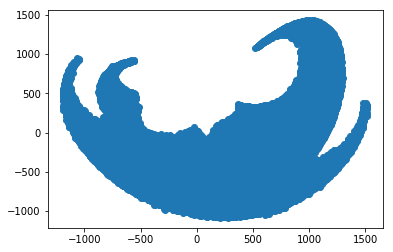

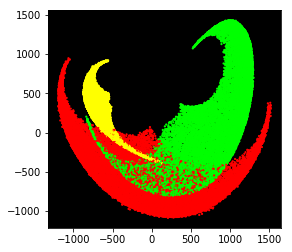

In [75]:
# Scatter plot ............ for 2 PCA
plt.scatter(Xpca2[:,0],Xpca2[:,1])
print(Xpca2.shape)


# Verify that they form three (mostly) separable clusters 

P = Xpca2
print("T=", T.shape)
print("P=", P.shape)

label0=0  # Triangle
label1=1  # Square
label2=2  # Pizza

# Draw Scatter Plot
# For best effect, points should not be drawn in sequence but in random order
np.random.seed(0)
randomorder=np.random.permutation(np.arange(len(T)))
randomorder=np.arange(len(T))

# Set colors
cols=np.zeros((len(T),4))     # Initialize matrix to hold colors

for i,j in enumerate(T):
    if(j == label0): #Female
        cols[i]= [1,1,0,1] # 0 points are yellow (with opacity 0.25)
    elif(j == label1): #Male
        cols[i]= [1,0,0,1] # 1 points are red (with opacity 0.25)
    else:   #Children
        cols[i]= [0,1,0,1] # 2 points are green (with opacity 0.25)
        
#print("cols:",cols[1:20])

# Draw scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, facecolor='black')
ax.scatter(P[randomorder,0],P[randomorder,1],s=5,linewidths=0,facecolors=cols[randomorder,:],marker="o");
ax.set_aspect('equal')

#plt.gca().invert_yaxis()
plt.show()

# Its not clearly separable clusters. we see lot of overlap between clusters

### Apply Linear Classifiers - Logistic Regression on reduced PCA components (133)

In [45]:
timeit -n1 -r1 (logisticRegr.fit(Xpca, T[:,0]).score(Xtpca, Tt[:,0]))

47.8 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [76]:

resLR = logisticRegr.fit(Xpca, T[:,0]) #- Reverse
print("Logistic Regression fit done:", resLR) #0.78- Reverse
resLR.score(Xtpca, Tt[:,0]) #- Reverse

# Reverse Train and Test set

#resLR = logisticRegr.fit(Xt, Tt[:,0])  # Fit all 196 dims
#print("Logistic Regression fit done:", resLR) #0.78
#resLR.score(X, T[:,0])
#resLR.score(Xtpca, Tt[:,0]) # Check prediction on same training data


Logistic Regression fit done: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='ovr', n_jobs=10,
          penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=True)


0.7841

In [77]:
LR_result = logisticRegr.predict(Xtpca) #- Reverse
print(LR_result.shape, LR_result) #- Reverse

# Reverse Train and Test set
#LR_result = logisticRegr.predict(Xpca)
#LR_result = logisticRegr.predict(X) # check predicton on all 196 dims
#LR_result = logisticRegr.predict(Xtpca)# Check prediction on same training data
#print(LR_result.shape, LR_result)

# Predict probability
logisticRegr.predict_proba(Xtpca)


(10000,) [2 1 1 ... 1 1 2]


array([[2.51572140e-061, 2.48625431e-222, 1.00000000e+000],
       [1.50168579e-002, 9.84983133e-001, 9.23929615e-009],
       [1.01388769e-003, 9.98986103e-001, 9.44389501e-009],
       ...,
       [4.99444196e-001, 5.00555804e-001, 3.18041098e-012],
       [2.37198532e-005, 9.99976280e-001, 2.22149091e-010],
       [4.42990179e-055, 1.26897848e-200, 1.00000000e+000]])

### Compare LR result with actuals

In [78]:

def compareResults(X,T):
    TP = 0;
    
    for i,val in enumerate(X):
        if(X[i] == T[i]):
            TP = TP + 1
    return [TP, len(X)]      
    
print("Accuracy Results:", compareResults(LR_result,Tt))
        

Accuracy Results: [7841, 10000]


### Separate out classes 

LR_result: [2 1 1 2 1]
Xtpca: (10000, 133)
P test sample count for class 0,1,2: 2331 2505 5164


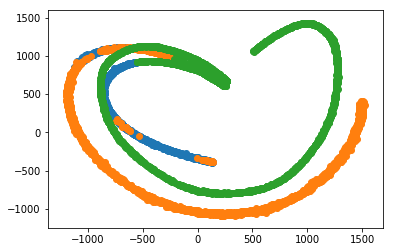

In [79]:
print("LR_result:",LR_result[0:5])

[P1, P2, P3, P4, P5] = splitDataIntoClasses(Xtpca,LR_result) 

print("Xtpca:" ,Xtpca.shape)

#print("P1:", P1[0:1])
#print("P2:" ,P2[0:1])
#print("P3:" ,P3[0:1])
print("P test sample count for class 0,1,2:", len(P1), len(P2), len(P3))

# Scatter plot ............
#plt.scatter(Pred[:,0],Pred[:,1])
plt.scatter(P1[:,0],P1[:,1])
plt.scatter(P2[:,0],P2[:,1])
plt.scatter(P3[:,0],P3[:,1])

In [80]:
# Separate out classes for actual distribution - in Train - Reverse

print("T:",T[0:5])

[P1, P2, P3, P4, P5] = splitDataIntoClasses(X,T) # check predicton on all 196 dims

#print("Xtpca:" ,Xtpca.shape)- Reverse
print("Xpca:" ,Xpca.shape)

#print("P1:", P1[0:1])
#print("P2:" ,P2[0:1])
#print("P3:" ,P3[0:1])
print("P test sample count for class 0,1,2:", len(P1), len(P2), len(P3))


T: [[2]
 [2]
 [2]
 [2]
 [0]]
Xpca: (60000, 133)
P test sample count for class 0,1,2: 19983 20128 19889


In [81]:
# Separate out classes for actual distribution - in Test

print("Tt:",Tt[0:5])

[P1, P2, P3, P4, P5] = splitDataIntoClasses(Xtpca,Tt) #LR_result)

print("Xtpca:" ,Xtpca.shape)

#print("P1:", P1[0:1])
#print("P2:" ,P2[0:1])
#print("P3:" ,P3[0:1])
print("P test sample count for class 0,1,2:", len(P1), len(P2), len(P3))


Tt: [[2]
 [1]
 [1]
 [2]
 [1]]
Xtpca: (10000, 133)
P test sample count for class 0,1,2: 3390 3293 3317


### Plot all classes from Testing set

Checking multiple testing vectors by plotting images.
Be patient:


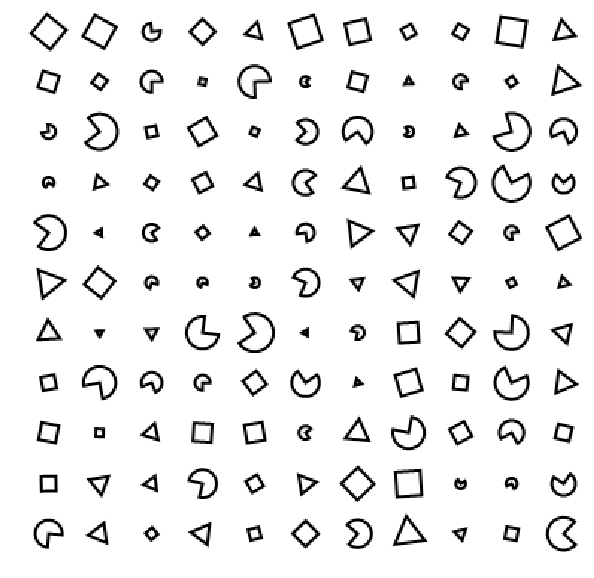

In [82]:
print("Checking multiple testing vectors by plotting images.\nBe patient:")
plt.close('all')
fig = plt.figure(figsize=(10,10))
nrows=11
ncols=11
for row in range(nrows):
    for col in range(ncols):
        #print("row*ncols+col + 1", row*ncols+col + 1)
        plt.subplot(nrows, ncols, row*ncols+col + 1)
        vectortoimg(Xt[row*ncols+col + 1],show=False)#- Reverse
        #vectortoimgRed(X[row*ncols+col + 1],show=False)
plt.show()

### Plot results to visualize 3 class distribution

LR predicted class 0 result
Checking multiple training vectors by plotting images for class: 0 
Be patient:
T.shape (10000,)


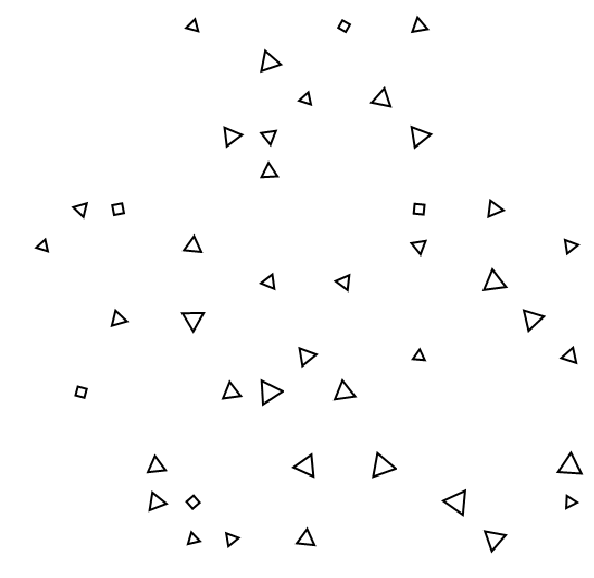

Actual class o result
Checking multiple training vectors by plotting images for class: 0 
Be patient:
T.shape (10000, 1)


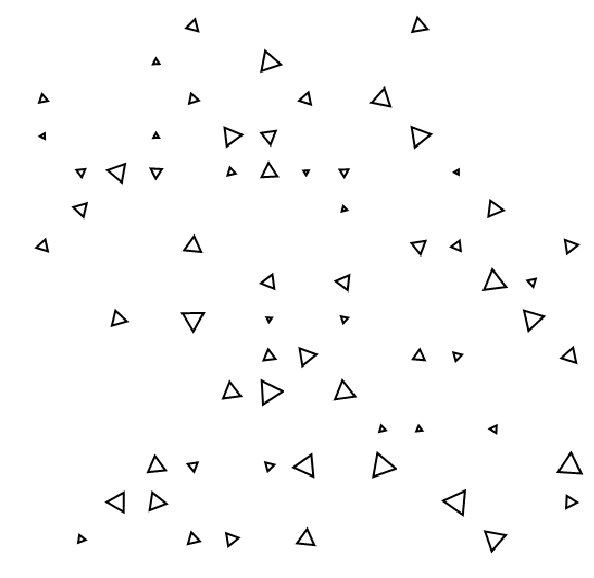

LR predicted class 1 result
Checking multiple training vectors by plotting images for class: 1 
Be patient:
T.shape (10000,)


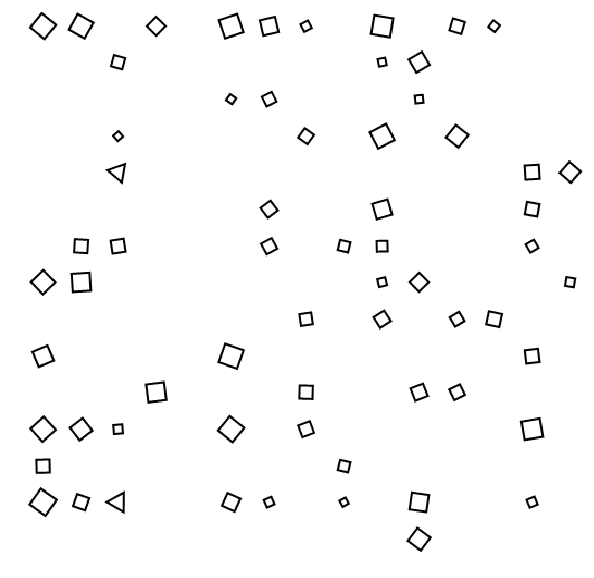

Actual class 1 result
Checking multiple training vectors by plotting images for class: 1 
Be patient:
T.shape (10000, 1)


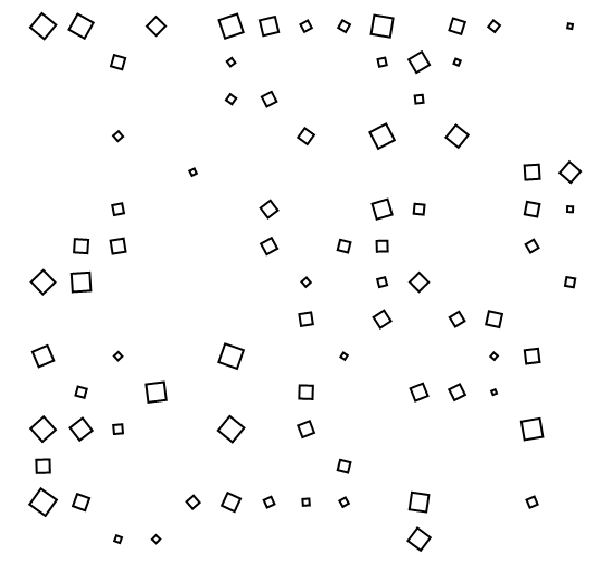

LR predicted class 2 result
Checking multiple training vectors by plotting images for class: 2 
Be patient:
T.shape (10000,)


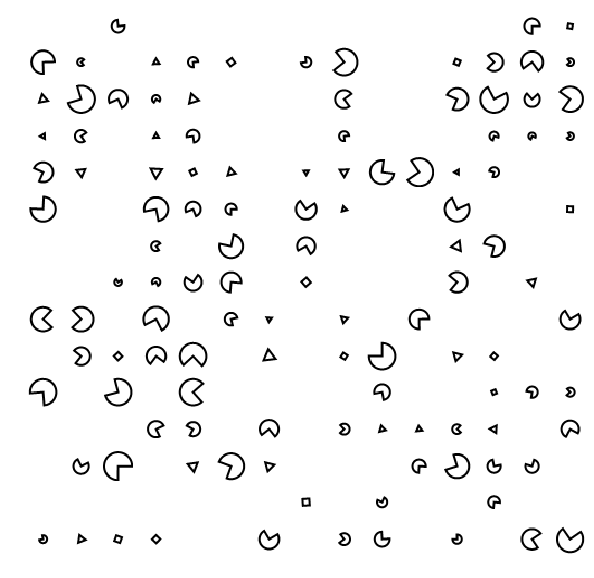

Actual class 2 result
Checking multiple training vectors by plotting images for class: 2 
Be patient:
T.shape (10000, 1)


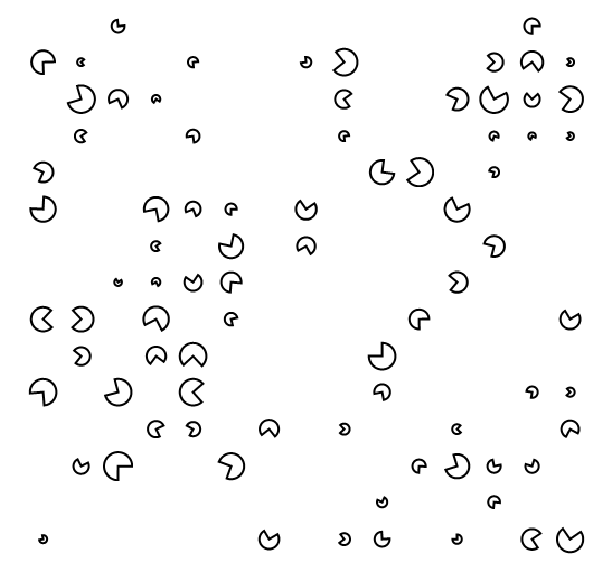

In [83]:
#Checking multiple training vectors by plotting images - for a class
def vectortoimgRedMlt(X,T,nrows,ncols,classLabel):
    print("Checking multiple training vectors by plotting images for class:",classLabel,"\nBe patient:")
    print("T.shape", T.shape)
    plt.close('all')
    fig = plt.figure(figsize=(10,10))
    for row in range(nrows):
        for col in range(ncols):
            if(classLabel == T[row*ncols+col + 1]):
                #print(T[row*ncols+col + 1], row*ncols+col + 1)
                plt.subplot(nrows, ncols, row*ncols+col + 1)
                vectortoimg(X[row*ncols+col + 1],show=False)
    plt.show()

    
print("LR predicted class 0 result") 
vectortoimgRedMlt(Xt,LR_result,15,15,0) #- Reverse
#vectortoimgRedMlt(Xt,LR_result,11,11,0)
print("Actual class o result")
vectortoimgRedMlt(Xt,Tt,15,15,0) #- Reverse
#vectortoimgRedMlt(X,T,11,11,0)

print("LR predicted class 1 result") 
vectortoimgRedMlt(Xt,LR_result,15,15,1) #- Reverse
#vectortoimgRedMlt(X,LR_result,11,11,1)
print("Actual class 1 result")
vectortoimgRedMlt(Xt,Tt,15,15,1) #- Reverse
#vectortoimgRedMlt(X,T,11,11,1)

print("LR predicted class 2 result") 
vectortoimgRedMlt(Xt,LR_result,15,15,2) #- Reverse
#vectortoimgRedMlt(X,LR_result,11,11,2)
print("Actual class 2 result")
vectortoimgRedMlt(Xt,Tt,15,15,2) #- Reverse
#vectortoimgRedMlt(X,T,11,11,2)


In [72]:
logisticRegr = LogisticRegression(solver = 'lbfgs', max_iter=10000,n_jobs=1,tol=0.0001, verbose=1, warm_start=True)

In [68]:
timeit -n1 -r1 (logisticRegr.fit(X, T[:,0]).score(Xt, Tt[:,0]))

/Users/monikabansal/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:718: UserWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number "
/Users/monikabansal/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:718: UserWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number "


16min 20s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed: 16.3min finished


In [74]:


resLRnew = logisticRegr.fit(X, T[:,0])
print("Logistic Regression fit done:", resLRnew) # 75%
resLR.score(Xt, Tt[:,0])


Logistic Regression fit done: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10000, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
          verbose=1, warm_start=True)


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.6s finished


0.756

In [73]:
timeit -n1 -r1 (logisticRegr.fit(X, T[:,0]).score(Xt, Tt[:,0]))

4min 22s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  4.4min finished
